## Tutorial Classification of European Land Cover Products using Sentinel-1

The focus of this task is the automated random sampling of the reference data and the SAR image data
and subsequent feeding into a machine learning framework. A study area is represented by a wetland site of Donana Delta in Spain.

#### import general python modules

In [1]:
from datetime import datetime

#### import of  functions from .py files

These functions are part of the SenClass project and are needed for computing and visualizing the results.

In [4]:
import geodata
import random_forest
import AccuracyAssessment
import pca

#### define input parameters

This is the only box which needs to be changed, all others runs automatically.
Two directories need to be defined with / as separator:

<ul>
<li> <i>path</i> a directory containing all the raster files provided with this tutorial.</li>
<li> <i>path_ref_p</i> a directory containing a reference product file, in this case  Global Surface Water Product (Seasonality) </li>
</ul>

In [5]:
path = '/path/to/data/'
path_ref_p = '/path/to/reference_data'  

Here will be defined a file extention for raster images and the name of the reference product file

In [ ]:
raster_ext = "tif"
ref_p_name = "seasonality_10W_40Nv1_3_2020_sub_reprojected.tif"

#### create the output directory and files 

In [6]:
out_folder_resampled_scenes = "resamp/"
out_folder_prediction = "results/"  

In [7]:
name_predicted_image = "base_prediction_nd_0"
name_tuned_predicted_image = "tune_prediction_nd_0"

#### values for reclassifying raster data

In [ ]:
raster_value = [0, 11, 12]
class_value = [100, 200, 300]

#### define parameters for sample selection

Furthermore, three processing parameters for sample selection can be adjusted:
<ul>
<li> <i>random_state</i></li>
<li> <i>train_size</i> Specifies how many samples are used for training</li>
<li> <i>sss</i> True: using stratified random sampling, False: using random sampling</li>
</ul>    

In [22]:
random_state = 0
train_size = 0.25  
sss = False 

#### Define the number of components for Principal Coponent Analysis

In [29]:
n_components = 0.95

#### define random forest parameter

As well, the following random forest parameters can be adjusted
<ul>
<li> <i>max_depth</i></li> The maximum depth of the tree, default none
<li> <i>n_estimator</i></li> The number of trees in the forest, default 100
<li> <i>n_cores</i></li> Defines number of cores to use, if -1 all cores are used
<li> <i>verbose</i></li> Shows output from rando mforrest in console
</ul>

In [27]:
max_depth = 3 
n_estimator = 2  
n_cores = 1
verbose = 1 

For the tuning can the following adjusted
<li> <i> min_depth_t </i></li>
<li> <i> max_depth_t </i></li>
<li> <i> min_estimator </i> minimum number of estimators</li>
<li> <i> max_estimator </i> maximum number of estimators</li>
<li> <i> value_generator </i> number of values to generate</li>
<li> <i> n_iter </i> number of parameter settings that are sampled</li>
<li> <i> cv </i> number of folds of cross validation</li>

In [28]:
min_depth_t = 3
max_depth_t = 10
min_estimator = 10  
max_estimator = 50  
value_generator = 5  
n_iter = 5    

### Functions

#### reprojecting and reclassifying raster data

The raster used as reference product is projected into the coordinate system of the satellite images. The satellite
images are not reprojected, but the pixel size is adjusted to that of the reference product.

In [11]:
out_ref_p = geodata.reproject_raster(path, path_ref_p, ref_p_name, raster_ext, out_folder_resampled_scenes)


####################   -   Preparing the Geodata   -   ####################

##########   -   Searching for files   -   ##########
D:/Uni/GEO419/T2/Abschlussaufgabe/Spain_Donana_S1-VV/ contains 90 raster files 


##########   -   Reprojecting data   -   ##########
reprojected D:/Uni/GEO419/T2/Abschlussaufgabe/seasonality_10W_40Nv1_3_2020_sub_reprojected_reprojected.tif file from EPSG 32629 to EPSG 32629 
location from resampled file: D:/Uni/GEO419/T2/Abschlussaufgabe/seasonality_10W_40Nv1_3_2020_sub_reprojected_reprojected_reprojected.tif

resampled file already exists
resampled file already exists
resampled file already exists
resampled file already exists
resampled file already exists
resampled file already exists
resampled file already exists
resampled file already exists
resampled file already exists
resampled file already exists
resampled file already exists
resampled file already exists
resampled file already exists
resampled file already exists
resampled file already exists
res

In [ ]:
geodata.reclass_raster(raster_value, class_value, out_ref_p)

#### select samples from scene(s)

The function select samples for training and testing. The user has the choice between two methods to select the
test and training pixels. If strat is set to true, the pixels and labels are selected using the sklearn algorithm
 <i>StratifiedShuffleSplit </i>. Otherwise, the pixels and labels are randomly selected from the data frame using the
sklearn algorithm  <i>train_test_split</i>.

In [12]:
x_train, y_train, data, mask = geodata.select_samples(path, path_ref_p, out_ref_p, out_folder_resampled_scenes,
                                                          raster_ext, train_size, random_state, sss)


####################   -   Start sample selection   -   ####################

##########   -   Searching for files   -   ##########
D:/Uni/GEO419/T2/Abschlussaufgabe/Spain_Donana_S1-VV/resamp/ contains 90 resampled raster files 


##########   -   Preparing data   -   ##########
Creating data frame with labels and pixel values from satellite images
Removing -99 and NaN-values from data frame

##########   -   Using train_test_split from sklearn.model_selection   -   ##########
616388 pixels used for training 



#### implement PCA Transformation

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.

In [13]:
# data, x_train = pca.principal(data, x_train, n_components)

#### create random forest

The RandomForest will be created with this function.

In [14]:
rf = random_forest.rf_create(max_depth, random_state, n_estimator, n_cores, verbose)

####################   -   Start RandomForest classification  -   ####################

##########   -   Creating RandomForest   -   ##########
RandomForest parameters: max_depth: 10, number of trees=10, used cpu cores=-1


#### train random forest

rf_fit will create the Random Forrest with the defined parameters and fit the model to the training data.


In [15]:
rf_fitted = random_forest.rf_fit(rf, x_train, y_train)
prediction = random_forest.rf_predict(data, rf_fitted)


##########   -   Fitting RandomForest   -   ##########


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   13.2s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.6s finished



##########   -   Start Prediction   -   ##########


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.1s finished


#### save as gtiff format

The function <i>prediction_to_gtiff</i> writes the predicted array to a GTIFF file.

In [19]:
geodata.prediction_to_gtiff(prediction, path, out_folder_prediction, name_predicted_image, out_ref_p, raster_ext,
                                mask)
#tuned_prediction = random_forest.rf_parameter_tuning(x_train, y_train, data, min_depth_t, max_depth_t,
#                                                          min_estimator, max_estimator, value_generator, n_iter,
#                                                          random_state, n_cores)
#geodata.prediction_to_gtiff(tuned_prediction, path, out_folder_prediction, name_tuned_predicted_image, out_ref_p,
#                                raster_ext, mask)

predicted image already exists

##########   -   Staring parameter tuning   -   ##########
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best performing RandomForestModel has the following parameters: RandomForestClassifier(max_depth=10, n_estimators=20) 


##########   -   save predicted image   -   ##########
GTIFF created from predicted labels


#### visualize the results

The function <i>tif_visualize</i> shows the classification result from the Global Water Surface Productn (Seasonality).

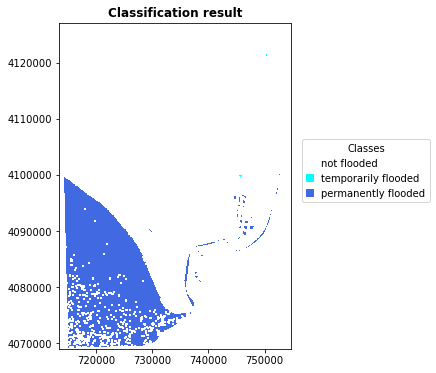

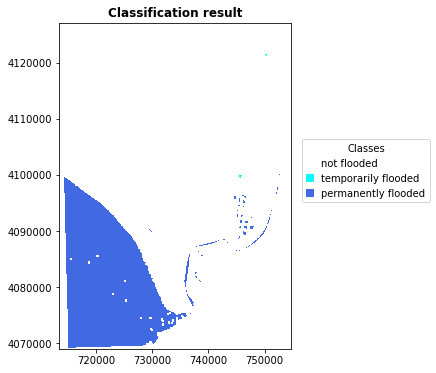

In [20]:
geodata.tif_visualize(path, out_folder_prediction, name_predicted_image, raster_ext) #visualize a base prediction
#geodata.tif_visualize(path, out_folder_prediction, name_tuned_predicted_image, raster_ext) #visualize a tuned prediction

#### get overall accuracy

Contains functions to assess the accuracy of the RF classifier. The following metrics are
evaluated:
<li>Confusion matrix (CM)</li>
<li>Kappa statistic (Kappa)</li>
<li>Classification report (precision, recall, f1-score, support)</li>

In [21]:
# Accuracy for a classification with the normal parameters
AccuracyAssessment.accuracy_assessment(prediction, out_ref_p)
# Accuracy for a classification with the tuned parameters
#AccuracyAssessment.accuracy_assessment(tuned_prediction, out_ref_p)


####################   -   Accuracy Assessment   -   ####################

##########   -   Confusion Matrix   -   ##########
Predicted      0.0     1.0    2.0   3.0     4.0   5.0  6.0  7.0  8.0  9.0    12.0      All
Actual                                                                                    
0.0        2910660   33868    965   142  152309    97    3    4    0    0   48721  3146769
1.0          76089  155887   1880   226   31142    14    1    1    0    0    1745   266985
2.0          21101   49656   6965   571   11645    14    0    0    0    0    1548    91500
3.0           9034    7617   2231  1481    3131   140    1    3    0    0    1261    24899
4.0           5372     998    579   563    3370   417    0    0    0    1    2325    13625
5.0           2609     142    105    70    1088   885    4    1    0    0    1831     6735
6.0           1332      64     25    25     319   157   21   81    4    2     944     2974
7.0           1039      10     14     5      41     3 